In [31]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [32]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats


In [33]:
import seaborn as sns

In [34]:
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [35]:
import seaborn as sns

In [36]:
%matplotlib inline
sns.set(style='whitegrid', palette='muted',font_scale=1.5)

In [37]:
RANDOM_SEED = 42

In [38]:
#columns = ['user','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv('AU_combined.csv', ' ')
df = df.dropna()
df.head()
print(df)

            accX      accY     accZ     gyroX     gyroY     gyroZ  \
0       0.000000  0.000000  0.00000 -0.157635 -0.235167  0.078527   
1       0.000000  0.000000  0.00000 -0.051955 -0.251050  0.114568   
2       0.000000  0.000000  0.00000  0.097096 -0.260824  0.178709   
3       0.000000  0.000000  0.00000  0.241871 -0.271208  0.261787   
4       0.000000  0.000000  0.00000  0.350605 -0.339625  0.315543   
...          ...       ...      ...       ...       ...       ...   
164635  0.909824  1.783735  9.77343 -0.026910 -0.138040 -0.154823   
164636  0.909824  1.783735  9.77343 -0.054399 -0.121546 -0.134054   
164637  0.909824  1.783735  9.77343 -0.058675 -0.003649 -0.096180   
164638  0.909824  1.783735  9.77343 -0.124648  0.131352 -0.081519   
164639  0.909824  1.783735  9.77343 -0.243156  0.273073 -0.049754   

           timestamp Activity  
0       15:44:16.039       SS  
1       15:44:16.053       SS  
2       15:44:16.072       SS  
3       15:44:16.092       SS  
4       15:

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164640 entries, 0 to 164639
Data columns (total 8 columns):
accX         164640 non-null float64
accY         164640 non-null float64
accZ         164640 non-null float64
gyroX        164640 non-null float64
gyroY        164640 non-null float64
gyroZ        164640 non-null float64
timestamp    164640 non-null object
Activity     164640 non-null object
dtypes: float64(6), object(2)
memory usage: 11.3+ MB


In [40]:
countOfActivity = df['Activity'].value_counts()
print(countOfActivity)

NS    83151
SS    48285
LS    33204
Name: Activity, dtype: int64


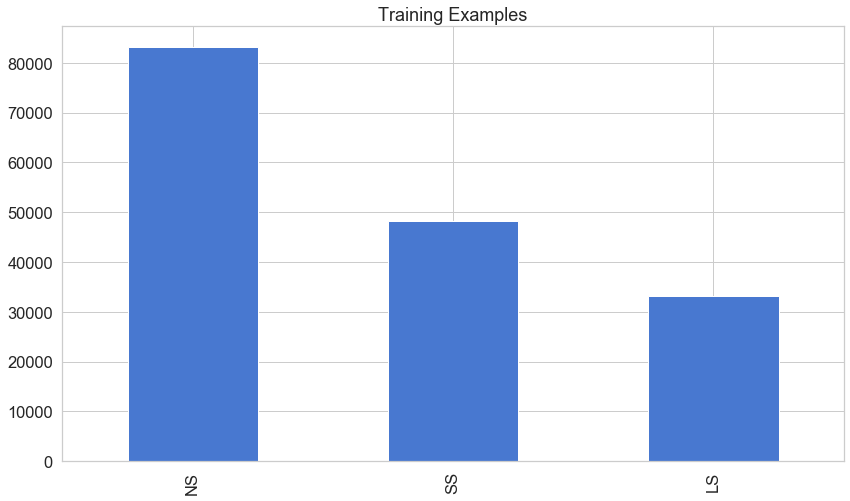

In [41]:
countOfActivity.plot(kind='bar', title='Training Examples', figsize=(14,8));

In [42]:
def plot_activity(activity,df):
    extractRowsOfActivity = (df['Activity'] == activity)
    data = df[extractRowsOfActivity]
    data = data[['accX', 'accY', 'accZ']]
    data = data[:100]
    
    ax = data.plot(subplots=True,figsize=(30,20),title=activity)

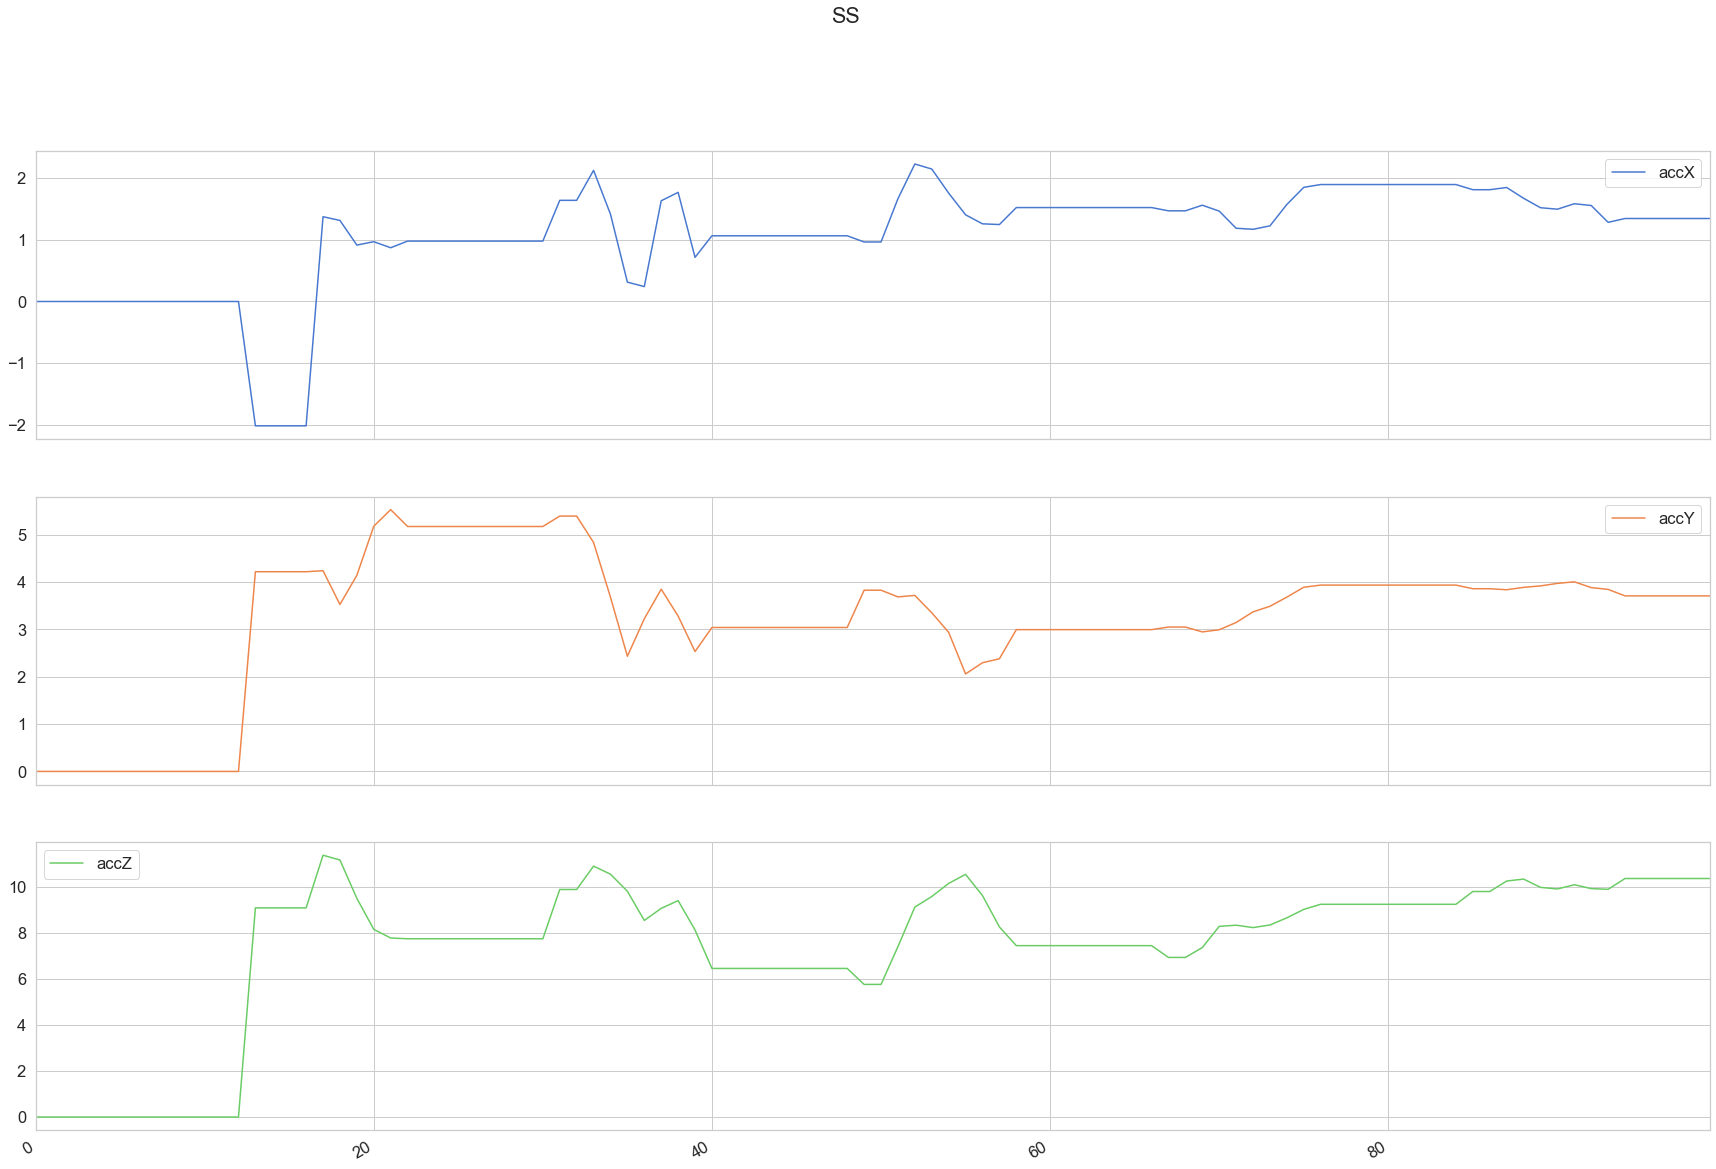

In [43]:
plot_activity("SS",df)

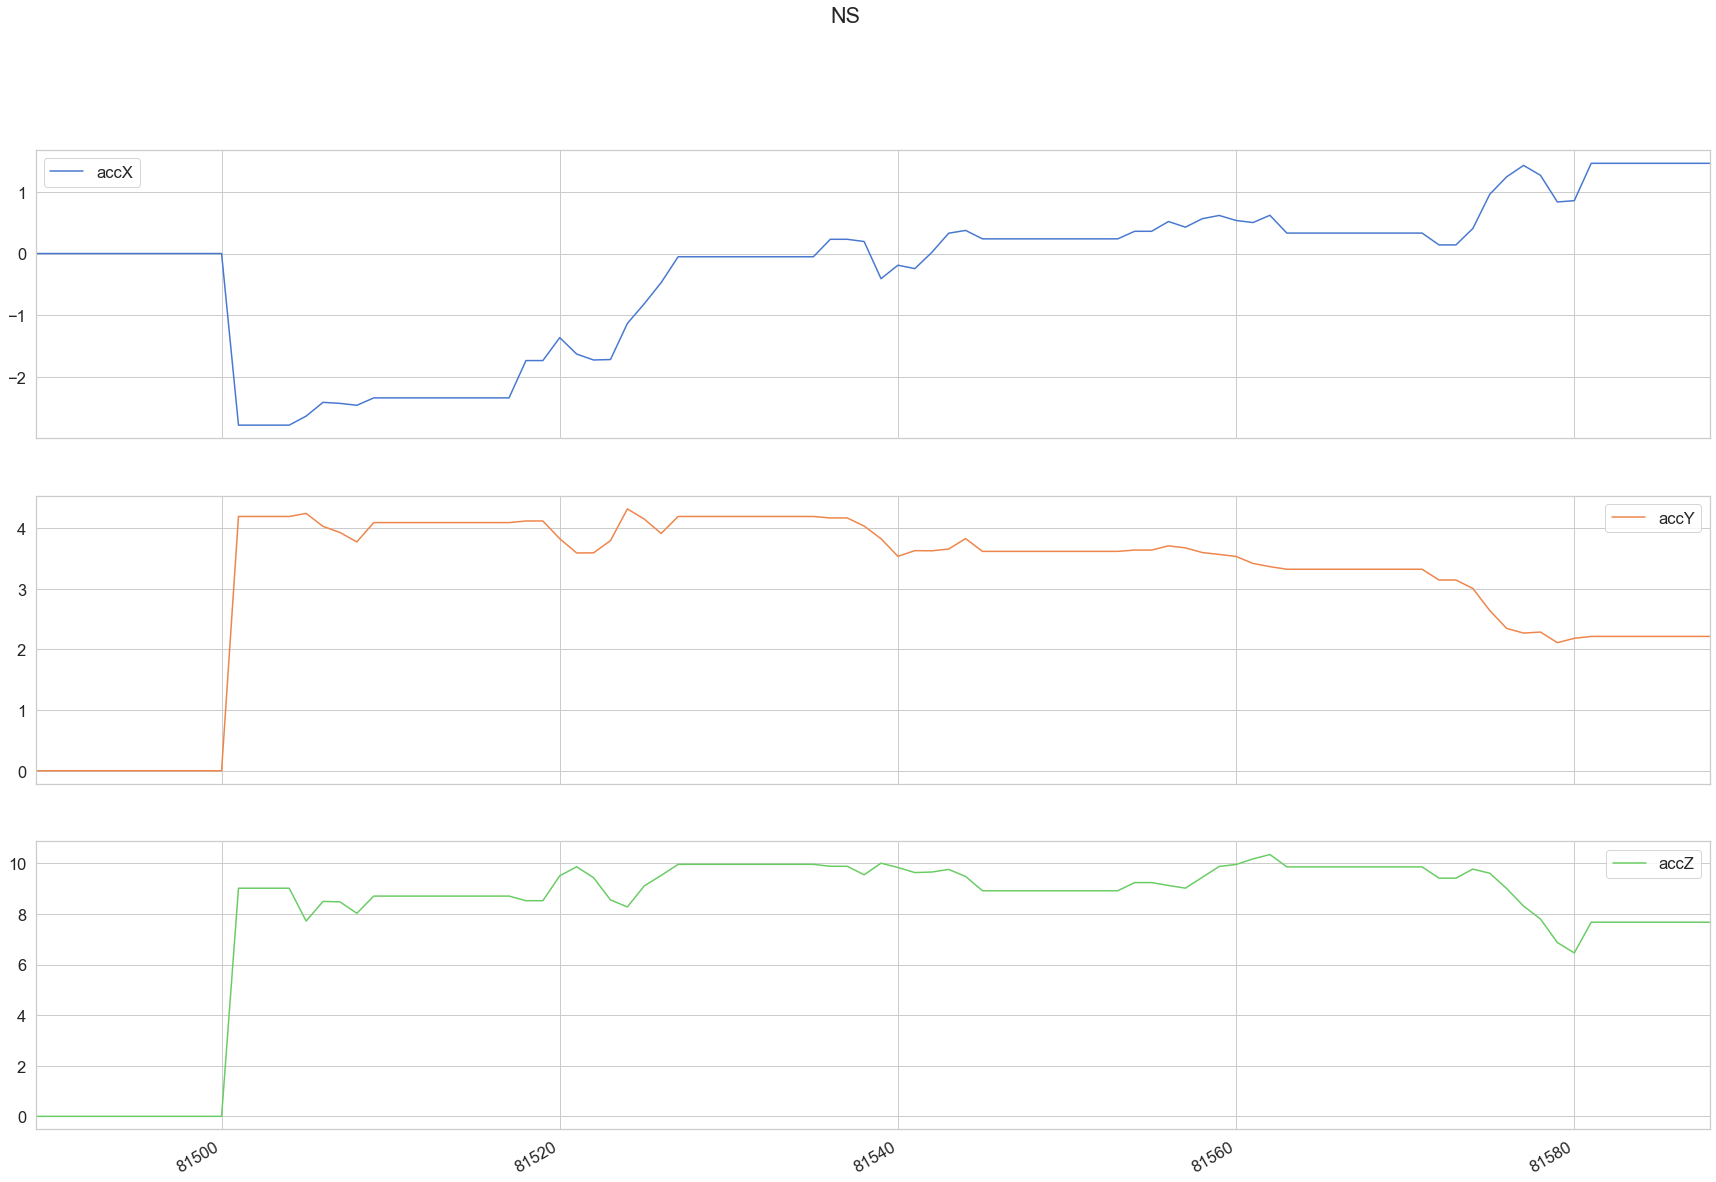

In [44]:
plot_activity("NS",df)

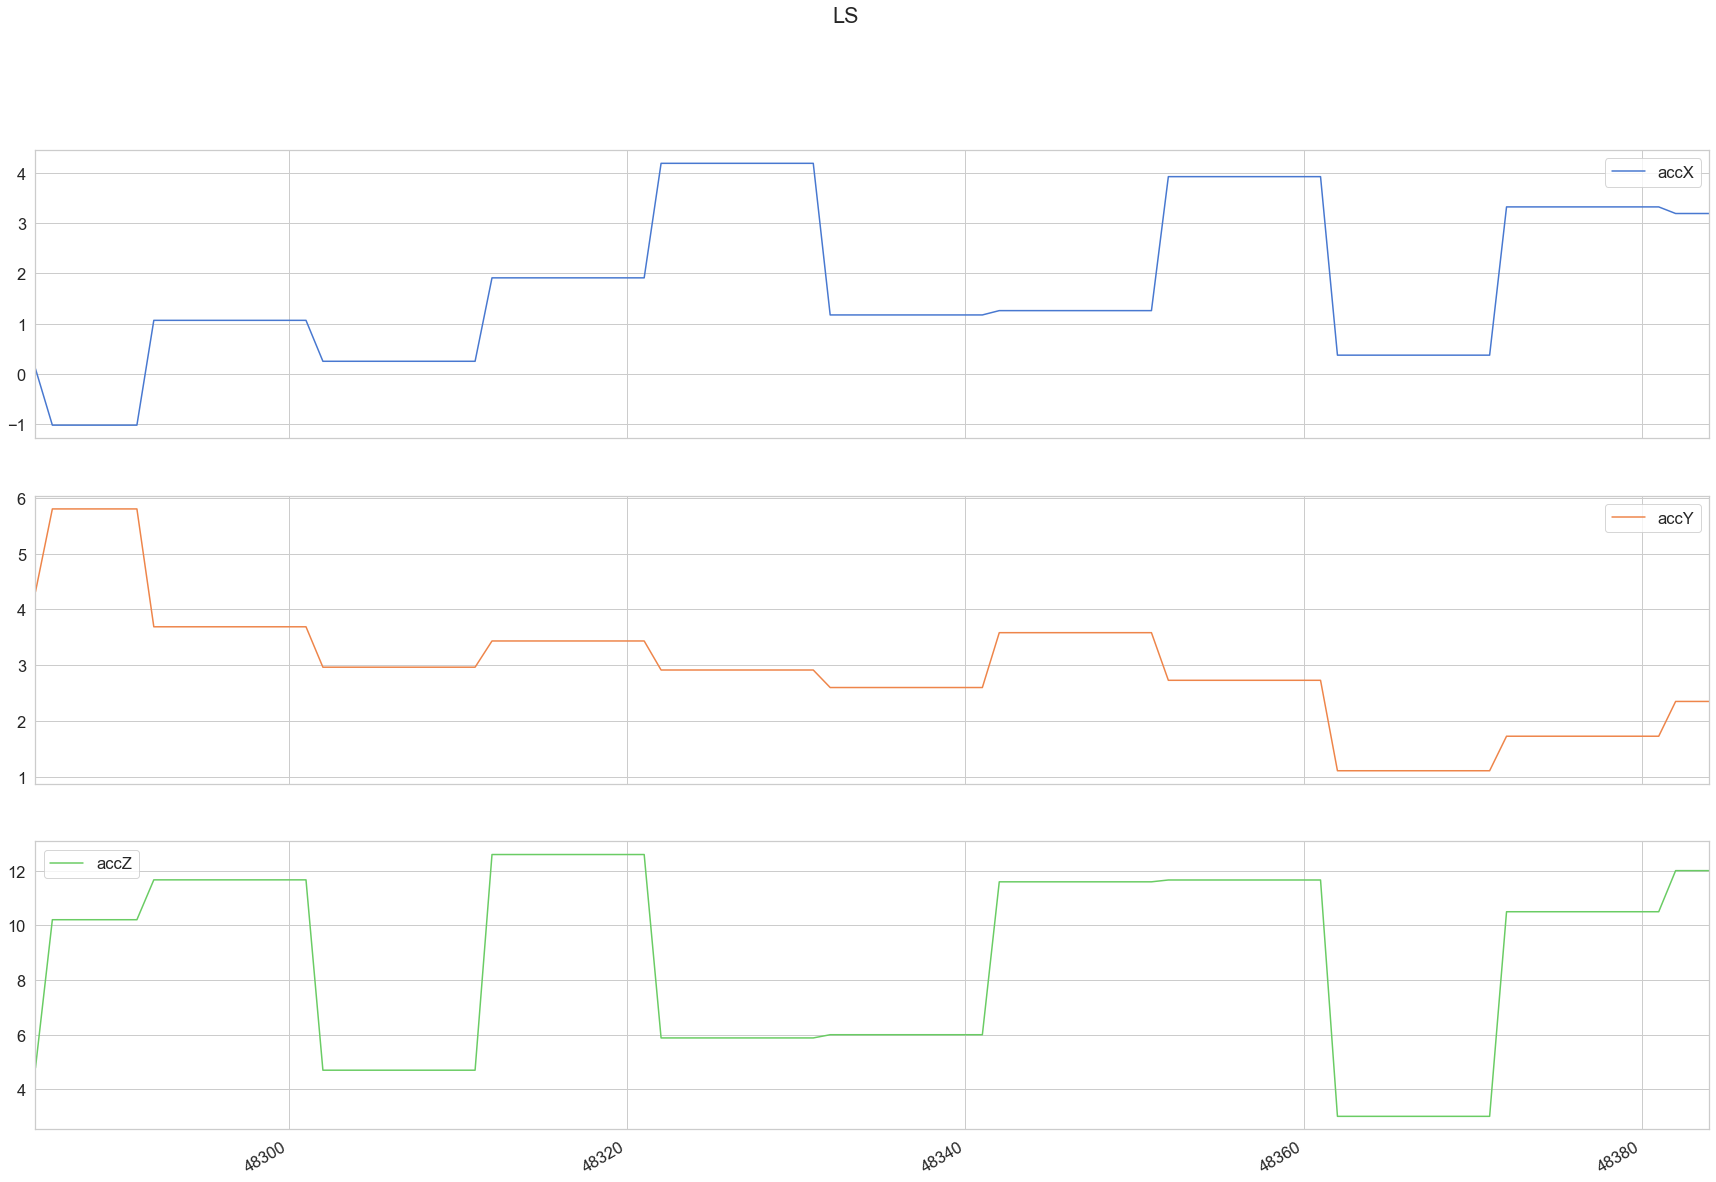

In [45]:
plot_activity("LS",df)


In [46]:
#Preprocessing
N_TIME_STEPS = 100
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['accX'].values[i: i + N_TIME_STEPS]
    ys = df['accY'].values[i: i + N_TIME_STEPS]
    zs = df['accZ'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])
    label = label[0][0]
    segments.append([xs,ys,zs])
    labels.append(label)

In [47]:

np.array(segments).shape


(8227, 3, 100)

In [48]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
reshaped_segments.shape

(8227, 100, 3)

In [49]:
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [50]:
print(labels)
print(labels.shape)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
(8227, 3)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size = 0.2, random_state = RANDOM_SEED)

In [52]:
len(X_train)

6581

In [53]:
len(X_test)

1646

In [54]:
#LSTM Model
N_CLASSES = 3
N_HIDDEN_UNITS = 64

In [55]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random.normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random.normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random.normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random.normal([N_CLASSES]))
    }
    
    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)
    
    #stack 2 LSTM layers
    lstm_layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_layers)
    
    #lstm_layers = [tf.keras.layers.LSTMCell(N_HIDDEN_UNITS) for _ in range(2)]
    #rnn = tf.keras.layers.StackedRNNCells(lstm_layers)
    
    outputs, _ = tf.compat.v1.nn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    lstm_last_output = outputs[-1]
    #c = tf.Variable(tf.random.normal([step, N_CLASSES]), dtype=tf.float32)
    #lstm_last_output = rnn.get_initial_state(c)
    
    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [56]:


tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()

X = tf.compat.v1.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.compat.v1.placeholder(tf.float32, [None, N_CLASSES])






In [57]:
pred_Y = create_LSTM_model(X)
pred_softmax = tf.nn.softmax(pred_Y, name="y_")

In [58]:
L2_LOSS = 0.0015
l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

In [59]:
LEARNING_RATE = 0.0025

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [60]:
#TRAINING
N_EPOCHS = 40
BATCH_SIZE = 1024


In [46]:
saver = tf.compat.v1.train.Saver()

history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])

sess = tf.compat.v1.InteractiveSession()
sess.run(tf.compat.v1.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})
    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_train, Y: y_train})
    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
        
    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'Final Results: Accuracy: {acc_final} Loss: {loss_final}')

epoch: 1 test accuracy: 0.19137302041053772 loss: 1.7857441902160645
epoch: 2 test accuracy: 0.5145807862281799 loss: 1.621824026107788
epoch: 3 test accuracy: 0.6172539591789246 loss: 1.5473096370697021
epoch: 4 test accuracy: 0.6567436456680298 loss: 1.4359694719314575
epoch: 5 test accuracy: 0.677399754524231 loss: 1.3462278842926025
epoch: 6 test accuracy: 0.5698663592338562 loss: 1.4778097867965698
epoch: 7 test accuracy: 0.6919805407524109 loss: 1.3283541202545166
epoch: 8 test accuracy: 0.6695018410682678 loss: 1.2516429424285889
epoch: 9 test accuracy: 0.7308626770973206 loss: 1.1731548309326172
epoch: 10 test accuracy: 0.7533414363861084 loss: 1.1025010347366333
epoch: 11 test accuracy: 0.753948986530304 loss: 1.1136113405227661
epoch: 12 test accuracy: 0.7417982816696167 loss: 1.1422995328903198
epoch: 13 test accuracy: 0.7733900547027588 loss: 1.0381501913070679
epoch: 14 test accuracy: 0.7733900547027588 loss: 1.0339082479476929
epoch: 15 test accuracy: 0.7831105589866638 l

In [48]:

pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.compat.v1.train.write_graph(sess.graph_def, '.', './check3/har.pbtxt')
saver.save(sess, save_path = "./check3/har.ckpt")

from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework import graph_util
from tensorflow.python.tools import optimize_for_inference_lib

graph = tf.compat.v1.get_default_graph()
input_graph_def = graph.as_graph_def()
output_node_names = ['y_']

output_graph_def = tf.compat.v1.graph_util.convert_variables_to_constants(sess, input_graph_def, output_node_names)

with tf.compat.v1.gfile.GFile('./check3/frozen_har.pb', 'wb') as f:
    f.write(output_graph_def.SerializeToString())

    
input_graph_def_2 = tf.compat.v1.GraphDef()
with tf.compat.v1.gfile.Open('./check3/frozen_har.pb', "rb") as f:
    data = f.read()
    input_graph_def_2.ParseFromString(data)
    
output_graph_def_2 = optimize_for_inference_lib.optimize_for_inference(
        input_graph_def_2,
        ["input"],
        ["y_"],
        tf.float32.as_datatype_enum)

f = tf.compat.v1.gfile.FastGFile("./check3/optimized_har.pb","wb")
f.write(output_graph_def_2.SerializeToString())

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
Instructions for updating:
Use tf.gfile.GFile.


In [49]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

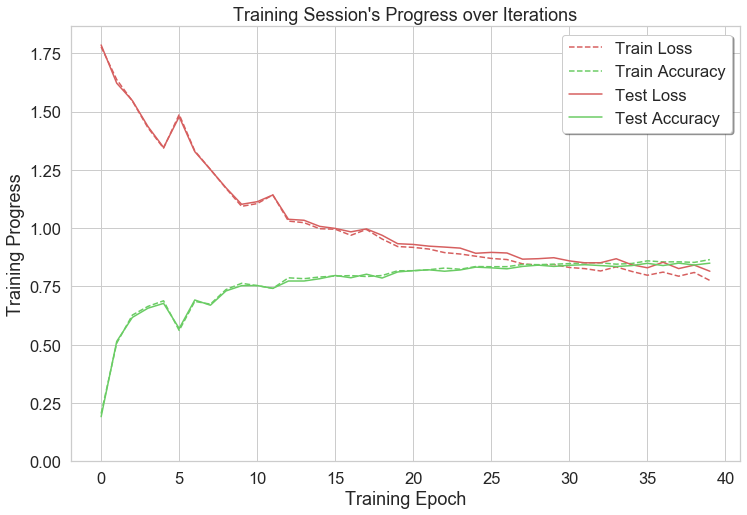

In [50]:

plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train Loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train Accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test Loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test Accuracy")

plt.title("Training Session's Progress over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

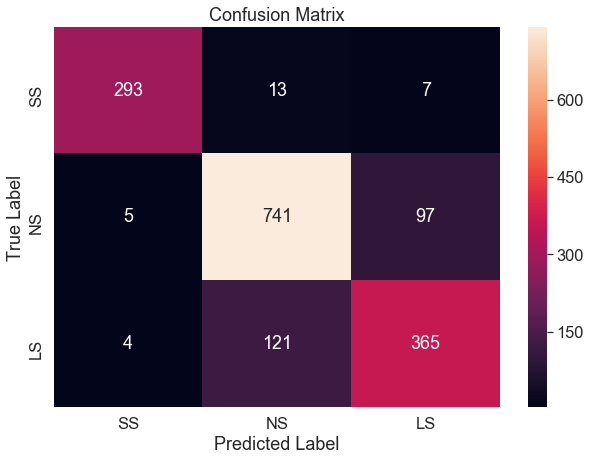

In [74]:

LABELS = ['SS', 'NS', 'LS']

max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
fig = plt.figure(figsize=(10,7))
ax = sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show();



In [75]:
pd.crosstab(max_test, max_predictions, rownames=['True'], colnames=['Predicted']).apply(lambda r: 100.0 * r/r.sum())



Predicted,0,1,2
True,,,
0,97.019868,1.485714,1.492537
1,1.655629,84.685714,20.682303
2,1.324503,13.828571,77.825160


In [77]:
print(labels[1])

[0. 0. 1.]
